In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 선수 연봉 데이터 크롤링

- 2014년부터 2023년까지의 선수 연봉 데이터를 얻기 위한 작업
- BeautifulSoup4를 활용한 웹 스크랩핑
- 데이터는 http://www.capology.com 로부터 추출

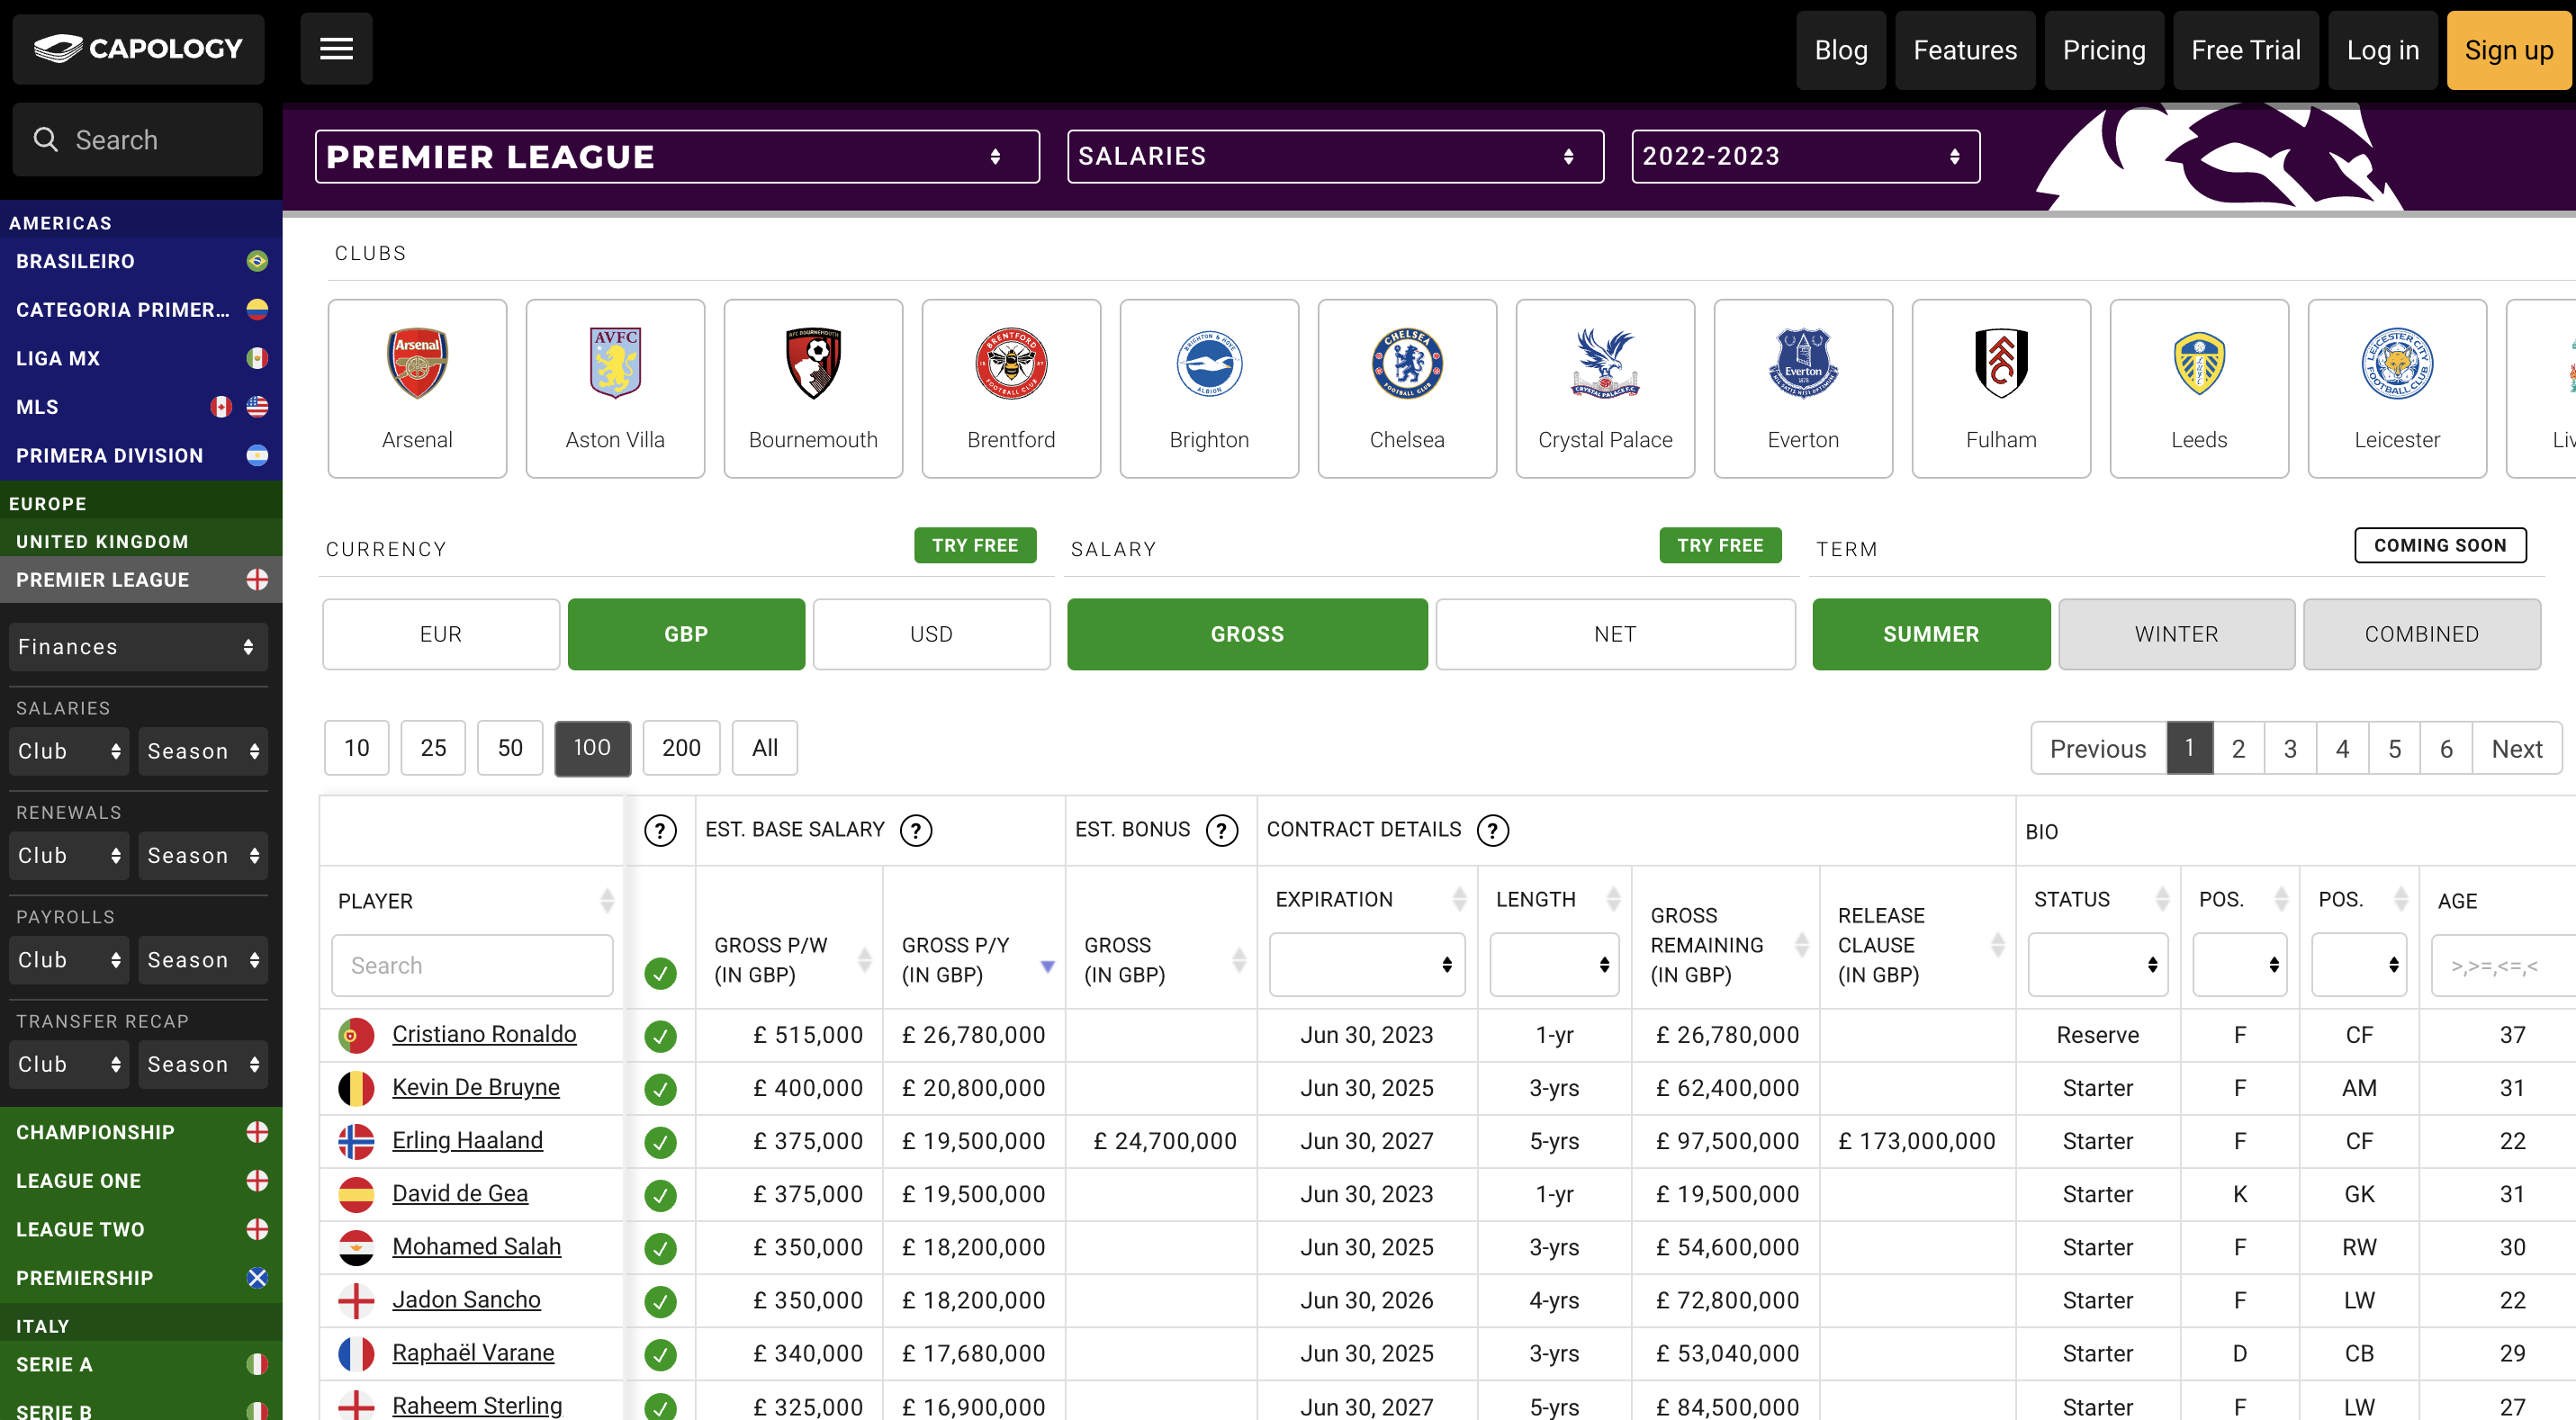

# 필수 라이브러리 설치 및 불러오기

In [2]:
### 필요시 실행 ###
# ! pip install beautifulsoup4
# ! pip install requests
# ! pip list

In [3]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import requests
import re
from bs4 import BeautifulSoup

# 함수 정의

In [4]:
# 시즌별 해당 리그의 각 팀 url을 반환하는 함수
def grab_urls(league, year):
    # 리그와 년도에 따라 url 할당
    url = 'https://www.capology.com{}/salaries/{}-{}/'.format(league, year, year + 1)
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'lxml')
    scripts = soup.find('div', {'class':"col s12 team-row"})
    salary_pages = []
    # 각 팀의 HTML 주소를 salary_pages 리스트에 추가
    for a in scripts.find_all('a', href=True):
        salary_pages.append(['https://www.capology.com/' + a['href'],re.findall(r'/club/(.*)/salaries',a['href'])[0], year])
    return salary_pages

# 해당 팀과 년도의 연봉 데이터를 반환하는 함수
def grab_salary_data(url, team, year):
    # Load URL
    res = requests.get(url)
    soup = BeautifulSoup(res.content, 'lxml')
    # 연봉 정보를 담고있는 스크립트 탐색
    if year == 2022:
      scripts = soup.find_all('script')[14]
    else:
      scripts = soup.find_all('script')[13]
    strings = scripts.string
    # 선수 이름을 정규 표현식으로 표현
    players = re.findall(r"""loading='lazy'>(.*)</a>""",strings)
    # 선수의 포지션을 정규 표현식으로 표현
    positions = re.findall(r'position.: "(.*)"',strings)
    # 연봉 정보를 정규 표현식으로 표현
    salaries = re.findall(r'annual_gross_eur.: accounting.formatMoney."(.*)", "',strings)
    # ['선수명', '연봉', '포지션'] 컬럼을 가진 데이터프레임 생성
    df = pd.DataFrame(list(zip(players, salaries, positions)),
               columns =['Player', 'Salary (€/year)', 'Position'])
    # Descriptive columns
    df['Year'] = year
    df['Team'] = team
    df['Salary (€/year)'] = df['Salary (€/year)'].astype('int64')
    return df

In [5]:
# EPL 14-15 시즌부터 22-23까지의 연봉 데이터 추출
premier_league = pd.DataFrame(columns=['Player', 'Salary (€/year)', 'Position', 'Year', 'Team'])
# 2014 ~ 2023 이므로 다음과 같이 입력
for year in range(2014, 2023):
    urls = grab_urls('/uk/premier-league', year)
    for i in urls:
        # 생성된 데이터프레임을 합치는 작업
        premier_league = pd.concat([grab_salary_data(i[0], i[1], i[2]), premier_league], ignore_index=False)
premier_league['League'] = 'Premier League'

In [6]:
# 데이터 확인
premier_league['Year'].value_counts()

2015    794
2016    790
2018    769
2014    747
2017    735
2020    593
2021    562
2019    557
2022    524
Name: Year, dtype: int64

In [7]:
# 데이터프레임을 csv로 저장
# premier_league.to_csv('/content/drive/MyDrive/Colab Notebooks/salary_data.csv')